In [1]:
# Importamos las librerías y módulos que usaremos
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.api import SimpleExpSmoothing
from scipy.optimize import curve_fit

# Análisis de tendencias

Primero leemos los archivos y examinamos la serie temporal

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,15.689439,15.753504,15.621622,15.684434,15.684434,78169752
1,2010-01-05,15.695195,15.711712,15.554054,15.615365,15.615365,120067812
2,2010-01-06,15.662162,15.662162,15.174174,15.221722,15.221722,158988852
3,2010-01-07,15.250250,15.265265,14.831081,14.867367,14.867367,256315428
4,2010-01-08,14.814815,15.096346,14.742492,15.065566,15.065566,188783028


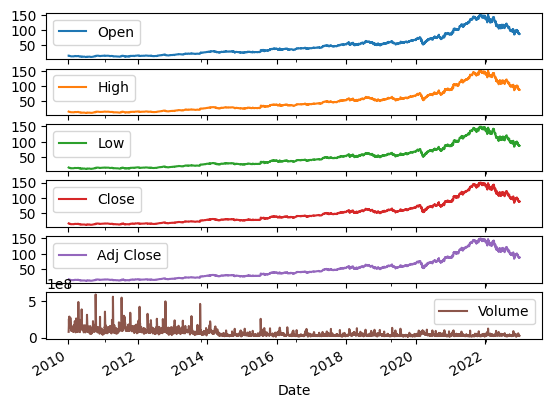

In [2]:
# Chequenado y guardando el nombre del archivo para leer
if os.path.exists('../../Data/googleStock/Google_Stock_Train (2010-2022).csv'):
    filename = '../../Data/googleStock/Google_Stock_Train (2010-2022).csv'
# leyendo con pandas
df = pd.read_csv(filename)  # esta línea abre el archivo, lo lee y crea el dataframe
print(df.dtypes)    # Siempre es importante saber qué tipo de dato es cada columna
df['Date'] = pd.to_datetime(df['Date'])
df.plot(x = 'Date',subplots = True)
df.head() # Mirando las primeras columnas

In [3]:
def ma(t, x, ws= 5):
    ''' Funcion para calcular la media movil de una serie temporal (simetrica)
        Entradas:
            - t: timestamps
            - x: serie datos
            - ws: tamaño de la ventana
        Salidas:
            - t: timestamps
            - y: media movil
    '''

    assert ws%2 == 1, 'ws debe ser entero e impar' 
    n_samples = x.shape[0]
    n_windows = n_samples-ws
    tstamps = []
    y = np.zeros(n_windows)
    for i in range(0, n_windows):
        right = n_samples - i 
        left = n_samples - i - ws 
        y[n_windows - i - 1] = x[left:right].mean() 
        tstamps.insert(0,t[(left+right)//2])
    return tstamps, y


In [4]:
# Analizamos la media movil 
ws = 21 # ancho de la ventana temporal
m_averaged = []
for c in list(df.columns)[1:]:
    t, d = ma(df['Date'],df[c].to_numpy(), ws=ws)
    m_averaged.append(d)
m_averaged = np.array(m_averaged).T
labels = list(df.columns)[1:]
print(t)

[Timestamp('2010-01-20 00:00:00'), Timestamp('2010-01-21 00:00:00'), Timestamp('2010-01-22 00:00:00'), Timestamp('2010-01-25 00:00:00'), Timestamp('2010-01-26 00:00:00'), Timestamp('2010-01-27 00:00:00'), Timestamp('2010-01-28 00:00:00'), Timestamp('2010-01-29 00:00:00'), Timestamp('2010-02-01 00:00:00'), Timestamp('2010-02-02 00:00:00'), Timestamp('2010-02-03 00:00:00'), Timestamp('2010-02-04 00:00:00'), Timestamp('2010-02-05 00:00:00'), Timestamp('2010-02-08 00:00:00'), Timestamp('2010-02-09 00:00:00'), Timestamp('2010-02-10 00:00:00'), Timestamp('2010-02-11 00:00:00'), Timestamp('2010-02-12 00:00:00'), Timestamp('2010-02-16 00:00:00'), Timestamp('2010-02-17 00:00:00'), Timestamp('2010-02-18 00:00:00'), Timestamp('2010-02-19 00:00:00'), Timestamp('2010-02-22 00:00:00'), Timestamp('2010-02-23 00:00:00'), Timestamp('2010-02-24 00:00:00'), Timestamp('2010-02-25 00:00:00'), Timestamp('2010-02-26 00:00:00'), Timestamp('2010-03-01 00:00:00'), Timestamp('2010-03-02 00:00:00'), Timestamp('20

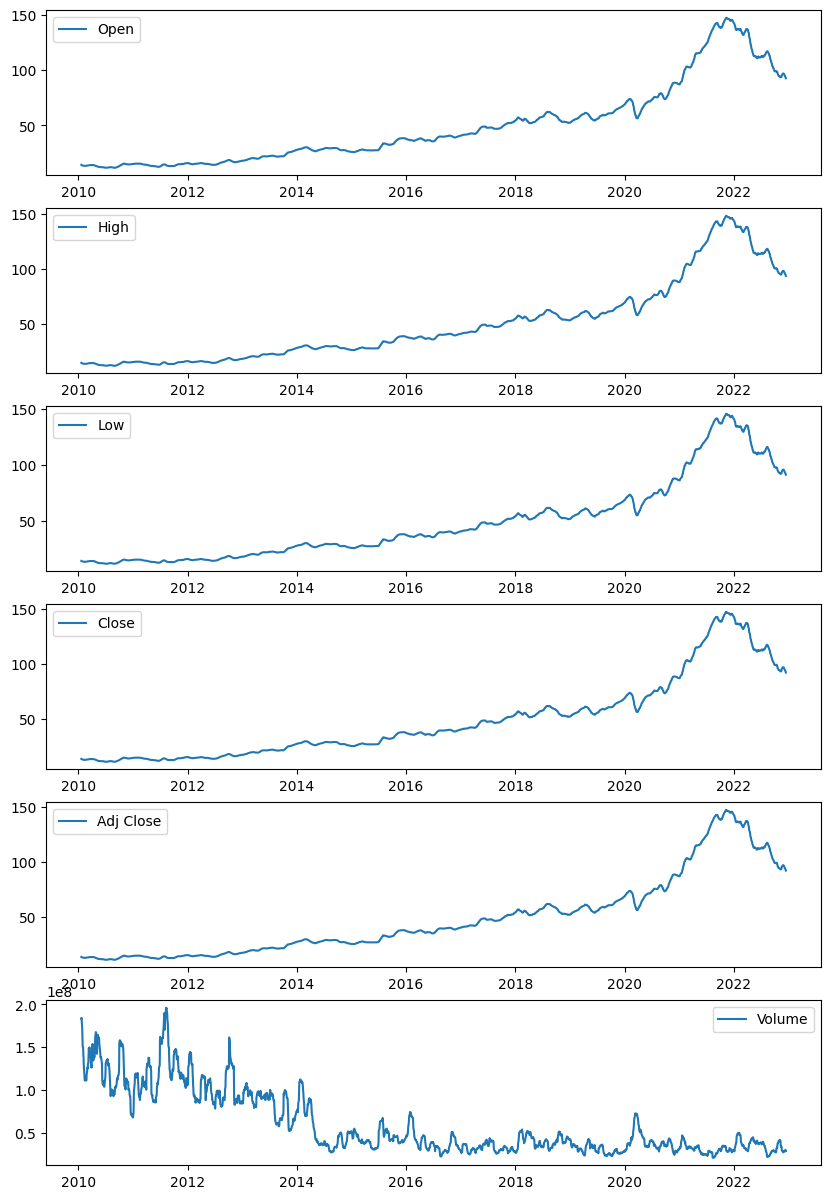

In [5]:
fig, axs = plt.subplots(len(labels),1, figsize=(10,15))
for i in range(len(labels)):
    axs[i].plot(t, m_averaged[:,i], label = labels[i])
    axs[i].legend()
plt.show()

## Analizando tendencias lineales

In [6]:
def lineal(x, a, b):
    return a*x + b

def cuadratica(x,a,b,c):
    return a*x**2 + b*x + c


In [7]:
# Para fitear funciones necesitamos pasar los timestamps a algún formato numérico
# Es usual utilizar unix epochs para trabajar con numeros de punto flotante
print(f'antes {type(t[0])}')
# create test data
dates = pd.to_datetime(t)
# calculate unix datetime
t_epochs =(dates - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
print(f'despues {type(t_epochs[0])}')

antes <class 'pandas._libs.tslibs.timestamps.Timestamp'>
despues <class 'numpy.longlong'>


In [8]:
def fit_batch(abcisas, data, function):
    assert type(data) == type(np.array([])), 'data tiene que ser un vector de numpy'
    if data.shape[0] != data.size:
        n_series = data.shape[1]
    else:
        n_series = data.size
    opt_vals = []
    errors = []
    for i in range(n_series):
        popt, pcov = curve_fit(function, abcisas, data[:,i])
        opt_vals.append(popt)
        errors.append(np.diag(pcov))
    
    return opt_vals, errors

def mae(y, y_hat):
    return np.abs(y-y_hat).mean(axis = 0)

def mse(y, y_hat):
    return ((y-y_hat)**2).mean(axis = 0)

In [9]:
opt_vals, errors = fit_batch(t_epochs, m_averaged, lineal)
print(f'parametros óptimos: {opt_vals}')
print(f'traza de la matriz de covarianza: {errors}')

parametros óptimos: [array([ 2.75189150e-07, -3.54695728e+02]), array([ 2.78468883e-07, -3.59020221e+02]), array([ 2.71926465e-07, -3.50414338e+02]), array([ 2.75229688e-07, -3.54754865e+02]), array([ 2.75229688e-07, -3.54754865e+02]), array([-2.54691547e-01,  4.33616723e+08])]
traza de la matriz de covarianza: [array([5.09239773e-18, 1.10376744e+01]), array([5.18801660e-18, 1.12449265e+01]), array([4.97212850e-18, 1.07769932e+01]), array([5.07581775e-18, 1.10017377e+01]), array([5.07581775e-18, 1.10017377e+01]), array([1.12235141e-05, 2.43267518e+13])]


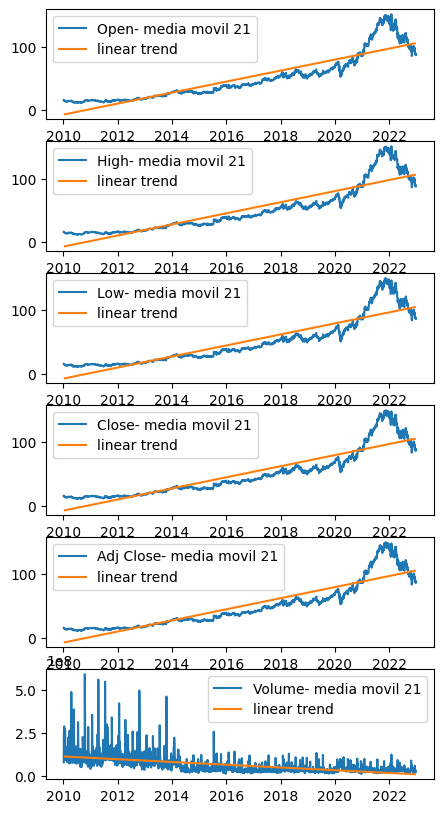

In [10]:
fig, axs = plt.subplots(len(labels),1, figsize=(5,10))
for i in range(len(labels)):
    axs[i].plot(df['Date'],df[labels[i]], label = labels[i] + '- media movil ' + str(ws))
    axs[i].plot(t,lineal(t_epochs,*opt_vals[i]), label = 'linear trend')
    axs[i].legend()


In [11]:
# para evaluar el error del fiteo usamos MAE y MSE sobre todos los datos
# evaluamos la tendencia lineal en los valores de las distribuciones
dates = pd.to_datetime(df['Date'])
t_epochs =(dates - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

predict = np.array([lineal(t_epochs,*opt_vals[i]) for i in range(len(labels))])
print(f'MAE para ajuste lineal de la MA(21):\n{mae(df[labels],predict.T)}')
print(f'Sqrt(MSE) para ajuste lineal de la MA(21):\n{np.sqrt(mse(df[labels],predict.T))}')


MAE para ajuste lineal de la MA(21):
Open         1.151423e+01
High         1.165962e+01
Low          1.135766e+01
Close        1.150723e+01
Adj Close    1.150723e+01
Volume       2.452406e+07
dtype: float64
Sqrt(MSE) para ajuste lineal de la MA(21):
Open         1.528005e+01
High         1.541231e+01
Low          1.510364e+01
Close        1.525534e+01
Adj Close    1.525534e+01
Volume       3.908626e+07
dtype: float64


parametros óptimos: [array([ 8.68750856e-16, -2.27458873e-06,  1.50417096e+03]), array([ 8.83814915e-16, -2.31552191e-06,  1.53207904e+03]), array([ 8.53886598e-16, -2.23422492e-06,  1.47664729e+03]), array([ 8.68037709e-16, -2.27245512e-06,  1.50258590e+03]), array([ 8.68037709e-16, -2.27245512e-06,  1.50258590e+03]), array([ 1.22286833e-09, -3.84380183e+00,  3.05018877e+09])]
traza de la matriz de covarianza: [array([2.27752624e-34, 1.96442475e-15, 1.04818922e+03]), array([2.28263895e-34, 1.96883458e-15, 1.05054225e+03]), array([2.24769337e-34, 1.93869311e-15, 1.03445920e+03]), array([2.26635898e-34, 1.95479269e-15, 1.04304968e+03]), array([2.26635898e-34, 1.95479269e-15, 1.04304968e+03]), array([5.53683393e-22, 4.77566116e-03, 2.54822515e+15])]
MAE para ajuste lineal de la MA(21):
Open         6.725535e+00
High         6.752276e+00
Low          6.656212e+00
Close        6.701169e+00
Adj Close    6.701169e+00
Volume       2.016371e+07
dtype: float64
Sqrt(MSE) para ajuste lineal de la

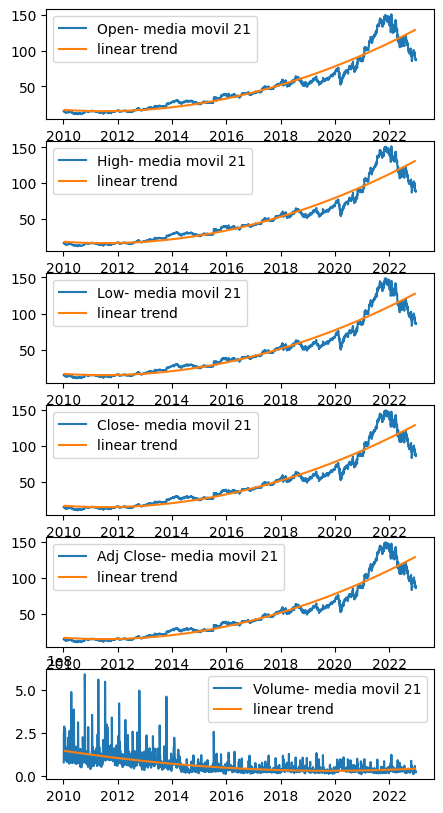

In [12]:
# Se puede hacer lo mismo a partir de un fiteo cuadrático

# create test data
dates = pd.to_datetime(t)
# calculate unix datetime
t_epochs =(dates - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
opt_vals, errors = fit_batch(t_epochs, m_averaged, cuadratica)
print(f'parametros óptimos: {opt_vals}')
print(f'traza de la matriz de covarianza: {errors}')

# el dibujito
fig, axs = plt.subplots(len(labels),1, figsize=(5,10))
for i in range(len(labels)):
    axs[i].plot(df['Date'],df[labels[i]], label = labels[i] + '- media movil ' + str(ws))
    axs[i].plot(t,cuadratica(t_epochs,*opt_vals[i]), label = 'linear trend')
    axs[i].legend()

# para evaluar el error del fiteo usamos MAE y MSE sobre todos los datos
dates = pd.to_datetime(df['Date'])
t_epochs =(dates - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

predict = np.array([cuadratica(t_epochs,*opt_vals[i]) for i in range(len(labels))])
print(f'MAE para ajuste lineal de la MA(21):\n{mae(df[labels],predict.T)}')
print(f'Sqrt(MSE) para ajuste lineal de la MA(21):\n{np.sqrt(mse(df[labels],predict.T))}')


Se observa que los errores se reducen bastante. Se pueden ensayar diferentes tipos de funciones, aquí mostraremos otro truco, que consiste en tomar el logaritmo natural de la distribución para ajustarla

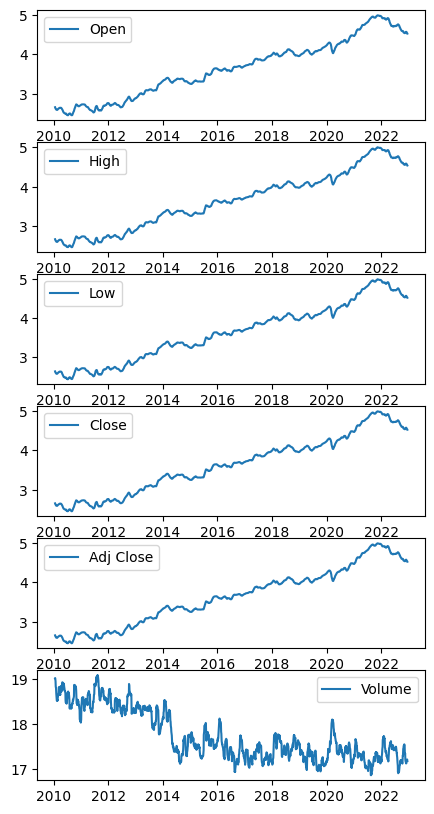

In [13]:
log_ma = np.log(m_averaged)
fig, axs = plt.subplots(len(labels),1, figsize=(5,10))
for i in range(len(labels)):
    axs[i].plot(t, log_ma[:,i], label = labels[i])
    axs[i].legend()

En las figuras previas se puede ver que un ajuste lineal puede ser útil

parametros óptimos: [array([ 6.02386504e-09, -5.19911337e+00]), array([ 6.03371855e-09, -5.20445257e+00]), array([ 6.01723106e-09, -5.19913866e+00]), array([ 6.02621073e-09, -5.20264111e+00]), array([ 6.02621073e-09, -5.20264111e+00]), array([-3.89130389e-09,  2.34514406e+01])]
traza de la matriz de covarianza: [array([3.37729007e-22, 7.32021145e-04]), array([3.32179515e-22, 7.19992739e-04]), array([3.40663916e-22, 7.38382511e-04]), array([3.35924588e-22, 7.28110106e-04]), array([3.35924588e-22, 7.28110106e-04]), array([2.20372696e-21, 4.77653598e-03])]
MAE para ajuste lineal de la MA(21):
Open         6.043566e+00
High         6.051928e+00
Low          5.997417e+00
Close        6.023347e+00
Adj Close    6.023347e+00
Volume       2.126726e+07
dtype: float64
Sqrt(MSE) para ajuste lineal de la MA(21):
Open         1.098098e+01
High         1.098536e+01
Low          1.091471e+01
Close        1.095796e+01
Adj Close    1.095796e+01
Volume       3.798321e+07
dtype: float64


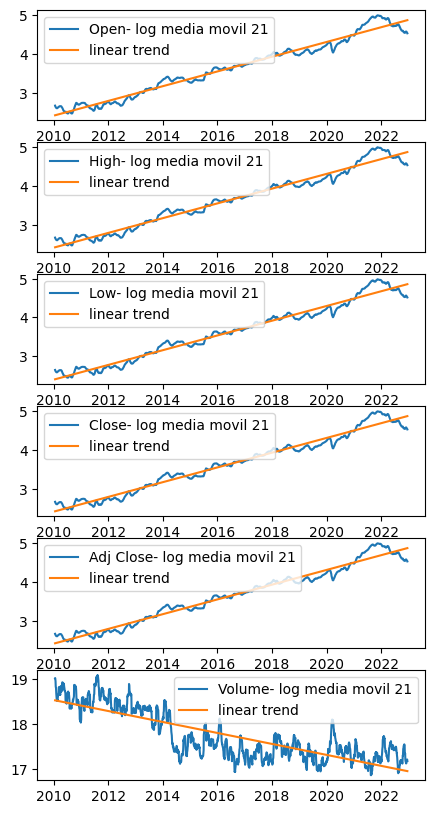

In [14]:
# create test data
dates = pd.to_datetime(t)
# calculate unix datetime
t_epochs =(dates - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
opt_vals, errors = fit_batch(t_epochs, log_ma, lineal)
print(f'parametros óptimos: {opt_vals}')
print(f'traza de la matriz de covarianza: {errors}')

# el dibujito
fig, axs = plt.subplots(len(labels),1, figsize=(5,10))
for i in range(len(labels)):
    axs[i].plot(dates, log_ma[:,i], label = labels[i] + '- log media movil ' + str(ws))
    axs[i].plot(t,lineal(t_epochs,*opt_vals[i]), label = 'linear trend')
    axs[i].legend()

# para evaluar el error del fiteo usamos MAE y MSE sobre todos los datos
dates = pd.to_datetime(df['Date'])
t_epochs =(dates - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

predict = np.array([np.exp(lineal(t_epochs,*opt_vals[i])) for i in range(len(labels))])
print(f'MAE para ajuste lineal de la MA(21):\n{mae(df[labels],predict.T)}')
print(f'Sqrt(MSE) para ajuste lineal de la MA(21):\n{np.sqrt(mse(df[labels],predict.T))}')


y se puede observar que este ajuste proporciona un error similar al obtenido con un ajuste cuadrático.

Finalmente, otra manera de extraer estacionalidad es a partir de derivadas. Para esto cabe recordar que la derivada de una función polinómica reduce en uno el orden del polinomio.

In [29]:
def deriv_fwd(x, y):
    return (y[1:]-y[:-1])/(x[1:]-x[:-1])

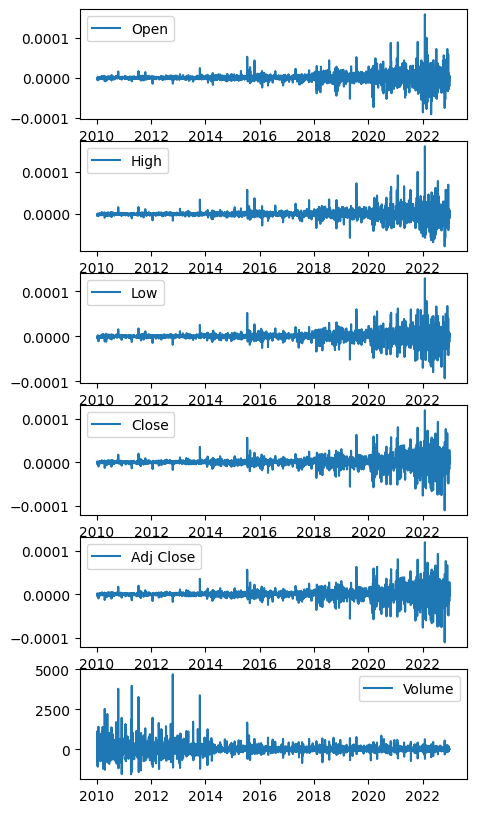

In [38]:
# create test data
dates = pd.to_datetime(df['Date'])
# calculate unix datetime
t_epochs =(dates - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

derivs = np.array([deriv_fwd(t_epochs.to_numpy(), df[l].to_numpy()) for l in labels]).T
# el dibujito
fig, axs = plt.subplots(len(labels),1, figsize=(5,10))
for i in range(len(labels)):
    axs[i].plot(dates.to_numpy()[1:], derivs[:,i], label = labels[i] )
    axs[i].legend()

# predict = np.array([np.exp(lineal(t_epochs,*opt_vals[i])) for i in range(len(labels))])
# print(f'MAE para ajuste lineal de la MA(21):\n{mae(df[labels],predict.T)}')
# print(f'Sqrt(MSE) para ajuste lineal de la MA(21):\n{np.sqrt(mse(df[labels],predict.T))}')

Las derivadas muestran un comportamiento plano, con una desviación estándar que varía en el tiempo. Se puede ajustar la tendencia lineal sacando la media de esta distribución, y luego hacer alguna transformación que permita ajustar la desviación estándar